In [1]:
import torch
import transformers
from transformers.data.processors.utils import InputExample
from transformers.data.processors.glue import glue_convert_examples_to_features
from transformers import get_linear_schedule_with_warmup
from transformers import glue_compute_metrics
from transformers import BertConfig, BertTokenizer, BertForSequenceClassification, AdamW, AutoTokenizer, AutoModelForSequenceClassification
from torch.utils.data import TensorDataset, DataLoader, RandomSampler, SequentialSampler
import zipfile
import urllib.request
import os
import pandas as pd
import numpy as np
import time
import datetime
import random
import tqdm
import json
from collections import defaultdict
from typing import List
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
warnings.simplefilter("ignore")

# If there's a GPU available...
if torch.cuda.is_available():
    # Tell PyTorch to use the GPU.    
    device = torch.device("cuda")
    print('There are %d GPU(s) available.' % torch.cuda.device_count())
    print('We will use the GPU:', torch.cuda.get_device_name(0))
# If not...
else:
    print('No GPU available, using the CPU instead.')
    device = torch.device("cpu")

There are 4 GPU(s) available.
We will use the GPU: NVIDIA A10G


In [2]:
# STANFORD_SNLI_URL = "https://nlp.stanford.edu/projects/snli/snli_1.0.zip"
DATA_DIR = "data"

# def download_and_extract(dataset_url, data_dir):
#     print("Downloading and extracting ...")
#     filename = "snli.zip"
#     urllib.request.urlretrieve(dataset_url, filename)
#     with zipfile.ZipFile(filename) as zip_ref:
#         zip_ref.extractall(data_dir)
#     os.remove(filename)
#     print("Completed!")

# download_and_extract(STANFORD_SNLI_URL, DATA_DIR)

## Prepare Datasets

In [9]:
DATA_DIR = "data"
def load_dataset(train_data, val_data, feature_columns, label_column, sep_char):
    pass

snli_folder = os.path.join(DATA_DIR, "snli_1.0")

train_path =  os.path.join(snli_folder, "snli_1.0_train.txt")
dev_path = os.path.join(snli_folder, "snli_1.0_dev.txt")

df_train = pd.read_csv(train_path, sep='\t')
df_val = pd.read_csv(dev_path, sep='\t')

df_train[['sentence1', 'sentence2', 'gold_label']].head(5)

,sentence1,sentence2,gold_label
0,A person on a horse jumps over a broken down a...,A person is training his horse for a competition.,neutral
1,A person on a horse jumps over a broken down a...,"A person is at a diner, ordering an omelette.",contradiction
2,A person on a horse jumps over a broken down a...,"A person is outdoors, on a horse.",entailment
3,Children smiling and waving at camera,They are smiling at their parents,neutral
4,Children smiling and waving at camera,There are children present,entailment


In [13]:
df_train.head()

,sentence1,sentence2,label
0,A person on a horse jumps over a broken down a...,A person is training his horse for a competition.,neutral
1,A person on a horse jumps over a broken down a...,"A person is at a diner, ordering an omelette.",contradiction
2,A person on a horse jumps over a broken down a...,"A person is outdoors, on a horse.",entailment
3,Children smiling and waving at camera,They are smiling at their parents,neutral
4,Children smiling and waving at camera,There are children present,entailment


In [10]:
df_train = df_train[['sentence1', 'sentence2', 'gold_label']]
df_train.rename(columns={"gold_label": "label"}, inplace=True)

In [14]:
df_val = df_val[['sentence1', 'sentence2', 'gold_label']]
df_val.rename(columns={"gold_label": "label"}, inplace=True)

In [15]:
df_train = df_train[df_train['label'] != '-']
df_val = df_val[df_val['label'] != '-'] 

In [16]:
df_train = df_train.head(5000)
df_val = df_val.head(500)

## Prepare Pre-trained Model and Tokenizer

In [90]:
# model_name = "distilbert-base-uncased"
# tokenizer_name = "distilbert-base-uncased"

# model_name = "roberta-base"
tokenizer_name = "roberta-base"

tokenizer = AutoTokenizer.from_pretrained(tokenizer_name)
# model = AutoModelForSequenceClassification.from_pretrained(model_name, num_labels=3)

Some weights of the model checkpoint at roberta-base were not used when initializing RobertaForSequenceClassification: ['lm_head.dense.weight', 'lm_head.bias', 'roberta.pooler.dense.bias', 'roberta.pooler.dense.weight', 'lm_head.dense.bias', 'lm_head.layer_norm.bias', 'lm_head.layer_norm.weight', 'lm_head.decoder.weight']
- This IS expected if you are initializing RobertaForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing RobertaForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of RobertaForSequenceClassification were not initialized from the model checkpoint at roberta-base and are newly initialized: ['classifier.out_proj.weight', 'classi

## Tokenizing Datasets for Training

In [91]:
LABEL_LIST = ['contradiction', 'entailment', 'neutral']
MAX_SEQ_LENGHT = 128

def _create_examples(df, set_type):
    """ Convert raw dataframe to a list of InputExample. Filter malformed examples
    """
    examples = []
    for index, row in df.iterrows():
        if row['label'] not in LABEL_LIST:
            continue
        if not isinstance(row['sentence1'], str) or not isinstance(row['sentence2'], str):
            continue
            
        guid = f"{index}-{set_type}"
        examples.append(
            InputExample(guid=guid, text_a=row['sentence1'], text_b=row['sentence2'], label=row['label']))
    return examples

def _df_to_features(df, set_type):
    """ Pre-process text. This method will:
    1) tokenize inputs
    2) cut or pad each sequence to MAX_SEQ_LENGHT
    3) convert tokens into ids
    
    The output will contain:
    `input_ids` - padded token ids sequence
    `attention mask` - mask indicating padded tokens
    `token_type_ids` - mask indicating the split between premise and hypothesis
    `label` - label
    """
    examples = _create_examples(df, set_type)
    
    #backward compatibility with older transformers versions
    legacy_kwards = {}
    from packaging import version
    if version.parse(transformers.__version__) < version.parse("2.9.0"):
        legacy_kwards = {
            "pad_on_left": False,
            "pad_token": tokenizer.convert_tokens_to_ids([tokenizer.pad_token])[0],
            "pad_token_segment_id": 0,
        }
    
    return glue_convert_examples_to_features(
        examples=examples,
        tokenizer=tokenizer,
        label_list=LABEL_LIST,
        max_length=MAX_SEQ_LENGHT,
        output_mode="classification",
        **legacy_kwards,
    )

def _features_to_dataset(features, set_type):
    """ Convert features from `_df_to_features` into a single dataset
    """
    all_input_ids = torch.tensor([f.input_ids for f in features], dtype=torch.long)
    all_attention_mask = torch.tensor(
        [f.attention_mask for f in features], dtype=torch.long
    )
#     all_token_type_ids = torch.tensor(
#         [f.token_type_ids for f in features], dtype=torch.long
#     )
    all_labels = torch.tensor([f.label for f in features], dtype=torch.long)
    
    example_ids = []
    for index, _ in enumerate(features):
        if set_type == "train":
            code = '1111'
        else:
            code = '2222'
        example_ids.append(int(f"{code}{index}"))
    
    all_example_ids = torch.tensor([f for f in example_ids], dtype=torch.long)
    
    dataset = TensorDataset(
        all_input_ids, all_attention_mask, all_labels, all_example_ids
    )

    return dataset

train_features = _df_to_features(df_train, "train")
val_features = _df_to_features(df_val, "val")

train_dataset = _features_to_dataset(train_features, "train")
val_dataset = _features_to_dataset(val_features, "val")

In [92]:
train_features[0]

InputFeatures(input_ids=[0, 250, 621, 15, 10, 5253, 13855, 81, 10, 3187, 159, 16847, 4, 2, 2, 250, 621, 16, 1058, 39, 5253, 13, 10, 1465, 4, 2, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1], attention_mask=[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0], token_type_ids=None, label=2)

In [93]:
len(train_dataset)

5000

In [94]:
len(val_dataset)

500

In [95]:
# The DataLoader needs to know our batch size for training, so we specify it 
# here.
# For fine-tuning BERT on a specific task, the authors recommend a batch size of
# 16 or 32.

batch_size = 32

# Create the DataLoader for our training set.
train_sampler = RandomSampler(train_dataset)
train_dataloader = DataLoader(train_dataset, sampler=train_sampler, batch_size=batch_size)

# Create the DataLoader for our validation set.
validation_sampler = SequentialSampler(val_dataset)
validation_dataloader = DataLoader(val_dataset, sampler=validation_sampler, batch_size=batch_size)

## Fine-tune a Pre-trained Model

## Cartography Class

In [96]:
import torch
import transformers
from transformers import get_linear_schedule_with_warmup
from transformers import AdamW, AutoTokenizer, AutoModelForSequenceClassification
from torch.utils.data import TensorDataset, DataLoader, RandomSampler, SequentialSampler
import os
import pandas as pd
import numpy as np
import time
import datetime
import random
import tqdm
import json
from collections import defaultdict
from typing import List
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
warnings.simplefilter("ignore")

class Cartography:
    """
    Function to initialize variables and constants
    """
    def __init__(
        self, 
        # dataloader needs to be formatted as followings:
        # [0]: input ids 
        # [1]: attention masks
        # [2]: labels 
        # [3]: row ids or data point ids
        dataloader,
        num_labels,
        output_dir = "./",
        num_epochs = 4,
        device = 'cuda',
        model = 'roberta' # Model options include DistilBERT and RoBERTa.
    ):
        self.output_dir = output_dir
        
        if device.lower() != 'cpu':
            # If there's a GPU available...
            if torch.cuda.is_available():
                # Tell PyTorch to use the GPU.    
                self.device = torch.device("cuda")
                print('There are %d GPU(s) available.' % torch.cuda.device_count())
                print('Will use the GPU:', torch.cuda.get_device_name(0))
            # If not...
            else:
                print('No GPU available, using the CPU instead.')
                self.device = torch.device("cpu")
        else:
            self.device = torch.device("cpu")
        
        if dataloader:
            self.dataloader = dataloader
        else:
            print('Dataloader is empty!')
            raise NotImplementedError
        
        try:
            self.num_labels = int(num_labels)
        except:
            print('Invalid number of labels!')
            raise NotImplementedError
        
        if model.lower() == 'roberta':
            self.model_name = "roberta-base"
            self.tokenizer_name = "roberta-base"
        else:
            self.model_name = "distilbert-base-uncased"
            self.tokenizer_name = "distilbert-base-uncased"
        
        self.tokenizer = AutoTokenizer.from_pretrained(self.tokenizer_name)
        self.model = AutoModelForSequenceClassification.from_pretrained(self.model_name, num_labels=self.num_labels)
        self.model.cuda()
        
        # Number of training epochs (authors recommend between 2 and 4)
        self.epochs = num_epochs
        
        # Use AdamW (a class from the huggingface library (as opposed to pytorch)) for optimizer
        self.optimizer = AdamW(self.model.parameters(),lr = 2e-5,eps = 1e-8)
        
        # Total number of training steps is number of batches * number of epochs.
        self.total_steps = len(dataloader) * num_epochs

        # Create the learning rate scheduler.
        self.scheduler = get_linear_schedule_with_warmup(self.optimizer, 
                                                         num_warmup_steps = 0, 
                                                         num_training_steps = self.total_steps)
    
#     """
#     Function to calculate the accuracy of our predictions vs labels
#     """
#     def flat_accuracy(self, preds, labels):
#         pred_flat = np.argmax(preds, axis=1).flatten()
#         labels_flat = labels.flatten()
#         return np.sum(pred_flat == labels_flat) / len(labels_flat)

    """
    Function to takes a time in seconds and returns a string hh:mm:ss
    """    
    def format_time(self, elapsed):
        # Round to the nearest second.
        elapsed_rounded = int(round((elapsed)))

        # Format as hh:mm:ss
        return str(datetime.timedelta(seconds=elapsed_rounded))

    """
    Save training dynamics (logits) from given epoch as records of a `.jsonl` file.
    """
    def log_training_dynamics(self,
                              epoch,
                              train_ids,
                              train_logits,
                              train_golds):
        output_dir = self.output_dir
        td_df = pd.DataFrame({"guid": train_ids, f"logits_epoch_{epoch}": train_logits, "gold": train_golds})

        logging_dir = os.path.join(output_dir, f"training_dynamics")
        # Create directory for logging training dynamics, if it doesn't already exist.
        if not os.path.exists(logging_dir):
            os.makedirs(logging_dir)
        epoch_file_name = os.path.join(logging_dir, f"dynamics_epoch_{epoch}.jsonl")
        td_df.to_json(epoch_file_name, lines=True, orient="records")
        #   logger.info(f"Training Dynamics logged to {epoch_file_name}")
    
    """
    Function to customize trainable layers on the model
    """
    def set_trainable_layers(self, trainable_layers=None):
        total_params = 0
        trainable_params = 0

        # Set which layer is trainable or non-trainable
        if trainable_layers is None:
            trainable_layers = [self.model.bert.encoder.layer[-1], self.model.bert.pooler, self.model.classifier]
        for p in self.model.parameters():
                p.requires_grad = True
                total_params += p.numel()

        for layer in trainable_layers:
            for p in layer.parameters():
                p.requires_grad = True
                trainable_params += p.numel()

        print(f"Total parameters count: {total_params}")
        print(f"Trainable parameters count: {trainable_params}")
    
    """
    Function to generate training dynamics data
    """
    def training_dynamics_generation(self):
        # Set the seed value all over the place to make this reproducible.
        seed_val = 42
        random.seed(seed_val)
        np.random.seed(seed_val)
        torch.manual_seed(seed_val)
        torch.cuda.manual_seed_all(seed_val)
        torch.cuda.empty_cache()
        
        epochs = self.epochs
        train_dataloader = self.dataloader
        model = self.model
        device = self.device
        optimizer = self.optimizer
        scheduler = self.scheduler
        output_dir = self.output_dir
        
        # Measure how long the training epoch takes.
        t0 = time.time()
        
        # For each epoch...
        for epoch_i in range(0, epochs):

            # ========================================
            #               Perform Training
            # ========================================

            # Perform one full pass over the training set.

            print("")
            print('======== Epoch {:} / {:} ========'.format(epoch_i + 1, epochs))
            print('Training...')

            # Reset the total loss for this epoch.
            total_loss = 0

            # Put the model into training mode. Don't be mislead--the call to 
            # `train` just changes the *mode*, it doesn't *perform* the training.
            # `dropout` and `batchnorm` layers behave differently during training
            # vs. test (source: https://stackoverflow.com/questions/51433378/what-does-model-train-do-in-pytorch)
            model.train()
            model.zero_grad()

            # Initializing training dynamics variables
            train_ids = None
            train_golds = None
            train_logits = None
            train_losses = None

            # For each batch of training data...
            for step, batch in enumerate(train_dataloader):
                b_input_ids = batch[0].to(device)
                b_input_mask = batch[1].to(device)
                b_labels = batch[2].to(device)
                b_example_ids = batch[3].to(device)

                # Always clear any previously calculated gradients before performing a
                # backward pass. PyTorch doesn't do this automatically because 
                # accumulating the gradients is "convenient while training RNNs". 
                # (source: https://stackoverflow.com/questions/48001598/why-do-we-need-to-call-zero-grad-in-pytorch)
                model.zero_grad()        

                # Perform a forward pass (evaluate the model on this training batch).
                # This will return the loss (rather than the model output) because we
                # have provided the `labels`.
                # The documentation for this `model` function is here: 
                # https://huggingface.co/transformers/v2.2.0/model_doc/bert.html#transformers.BertForSequenceClassification
                outputs = model(b_input_ids, attention_mask=b_input_mask, labels=b_labels)
                loss = outputs[0]
                logits = outputs[1]

                if train_logits is None:  # Keep track of training dynamics.
                    train_ids = b_example_ids.detach().cpu().numpy()
                    train_logits = logits.detach().cpu().numpy()
                    train_golds = b_labels.detach().cpu().numpy()
                    train_losses = loss.detach().cpu().numpy()
                else:
                    train_ids = np.append(train_ids, b_example_ids.detach().cpu().numpy())
                    train_logits = np.append(train_logits, logits.detach().cpu().numpy(), axis=0)
                    train_golds = np.append(train_golds, b_labels.detach().cpu().numpy())
                    train_losses = np.append(train_losses, loss.detach().cpu().numpy())

                # Accumulate the training loss over all of the batches so that we can
                # calculate the average loss at the end. `loss` is a Tensor containing a
                # single value; the `.item()` function just returns the Python value from the tensor.
                total_loss += loss.item()

                # Perform a backward pass to calculate the gradients.
                loss.backward()

                # Clip the norm of the gradients to 1.0.
                # This is to help prevent the "exploding gradients" problem.
                torch.nn.utils.clip_grad_norm_(model.parameters(), 1.0)

                # Update parameters and take a step using the computed gradient.
                # The optimizer dictates the "update rule"--how the parameters are
                # modified based on their gradients, the learning rate, etc.
                optimizer.step()

                # Update the learning rate.
                scheduler.step()

            # Keep track of training dynamics for each epoch.
            self.log_training_dynamics(epoch=epoch_i,
                                      train_ids=list(train_ids),
                                      train_logits=list(train_logits),
                                      train_golds=list(train_golds))

            # Calculate the average loss over the training data.
            avg_train_loss = total_loss / len(train_dataloader)           
            print("")
            print("  Average training loss: {0:.2f}".format(avg_train_loss))

        print("")
        print("Whole training complete!")
        # Release model memory from GPU
        del model
        torch.cuda.empty_cache()
        # Measure how long this epoch took.
        print("Whole training took: {:}".format(self.format_time(time.time() - t0)))
        
    """
    Function to save trained model.
    Saving best-practices: if you use defaults names for the model, you can reload it using from_pretrained()
    """
    def save_model(self, output_dir):
        # Create output directory if needed
        if not os.path.exists(output_dir):
            os.makedirs(output_dir)

        print("Saving model to %s" % output_dir)

        # Save a trained model, configuration and tokenizer using `save_pretrained()`.
        # They can then be reloaded using `from_pretrained()`
        model_to_save = self.model.module if hasattr(self.model, 'module') else self.model  # Take care of distributed/parallel training
        model_to_save.save_pretrained(output_dir)
        self.tokenizer.save_pretrained(output_dir)
    
    """
    Given path to logged training dynamics, merge stats across epochs.
    Returns:
    - Dict between ID of a train instances and its gold label, and the list of logits across epochs.
    """
    def read_training_dynamics(self):
        epochs = self.epochs
        id_field='guid'
        train_dynamics = {}
        
        td_dir = os.path.join(self.output_dir, "training_dynamics/")
        if os.path.exists(td_dir):
            if epochs != -1:
                num_epochs = self.epochs
            else:
                num_epochs = len([f for f in os.listdir(td_dir) if os.path.isfile(os.path.join(td_dir, f))])

            print(f"Reading {num_epochs} files from {td_dir} ...")
            for epoch_num in tqdm.tqdm(range(num_epochs)):
                epoch_file = os.path.join(td_dir, f"dynamics_epoch_{epoch_num}.jsonl")
                assert os.path.exists(epoch_file)

                with open(epoch_file, "r") as infile:
                    for line in infile:
                        record = json.loads(line.strip())
                        guid = record[id_field]
                        if guid not in train_dynamics:
                            assert epoch_num == 0
                            train_dynamics[guid] = {"gold": record["gold"], "logits": []}
                        train_dynamics[guid]["logits"].append(record[f"logits_epoch_{epoch_num}"])

        print(f"Read training dynamics for {len(train_dynamics)} train instances.")
        return train_dynamics
    
    """
    Given a epoch-wise trend of train predictions, compute frequency with which
    an example is forgotten, i.e. predicted incorrectly _after_ being predicted correctly.
    Based on: https://arxiv.org/abs/1812.05159
    """    
    def compute_forgetfulness(self, correctness_trend: List[float]) -> int:
        if not any(correctness_trend):  # Example is never predicted correctly, or learnt!
            return 1000
        learnt = False  # Predicted correctly in the current epoch.
        times_forgotten = 0
        for is_correct in correctness_trend:
            if (not learnt and not is_correct) or (learnt and is_correct):
                # nothing changed.
                continue
            elif learnt and not is_correct:
                # Forgot after learning at some point!
                learnt = False
                times_forgotten += 1
            elif not learnt and is_correct:
                # Learnt!
                learnt = True
        return times_forgotten

    """
    Aggregate #times an example is predicted correctly during all training epochs.
    """
    def compute_correctness(self, trend: List[float]) -> float:
        return sum(trend)

    """
    Given the training dynamics (logits for each training instance across epochs), compute metrics
    based on it, for data map coorodinates.
    Computed metrics are: confidence, variability, correctness, forgetfulness, threshold_closeness---
    the last two being baselines from prior work
    (Example Forgetting: https://arxiv.org/abs/1812.05159 and
    Active Bias: https://arxiv.org/abs/1704.07433 respectively).
    Returns:
    - DataFrame with these metrics.
    - DataFrame with more typical training evaluation metrics, such as accuracy / loss.
    """
    def compute_train_dynamics(self):
        
        # Generate training dynamics data
        training_dynamics = self.read_training_dynamics()
        
        if len(training_dynamics) > 0:
            epochs = self.epochs
            confidence_ = {}
            variability_ = {}
            threshold_closeness_ = {}
            correctness_ = {}
            forgetfulness_ = {}

            # Functions to be applied to the data.
            variability_func = lambda conf: np.std(conf)
        #     if args.include_ci:  # Based on prior work on active bias (https://arxiv.org/abs/1704.07433)
        #         variability_func = lambda conf: np.sqrt(np.var(conf) + np.var(conf) * np.var(conf) / (len(conf)-1))
            threshold_closeness_func = lambda conf: conf * (1 - conf)

            loss = torch.nn.CrossEntropyLoss()

            num_tot_epochs = len(list(training_dynamics.values())[0]["logits"])
            print(f"Computing training dynamics across {num_tot_epochs} epochs")
            print("Metrics computed: confidence, variability, correctness, forgetfulness, threshold_closeness")

            logits = {i: [] for i in range(num_tot_epochs)}
            targets = {i: [] for i in range(num_tot_epochs)}
            training_accuracy = defaultdict(float)

            for guid in tqdm.tqdm(training_dynamics):
                correctness_trend = []
                true_probs_trend = []

                record = training_dynamics[guid]
                for i, epoch_logits in enumerate(record["logits"]):
                    probs = torch.nn.functional.softmax(torch.Tensor(epoch_logits), dim=-1)
                    true_class_prob = float(probs[record["gold"]])
                    true_probs_trend.append(true_class_prob)

                    prediction = np.argmax(epoch_logits)
                    is_correct = (prediction == record["gold"]).item()
                    correctness_trend.append(is_correct)

                    training_accuracy[i] += is_correct
                    logits[i].append(epoch_logits)
                    targets[i].append(record["gold"])

                correctness_[guid] = self.compute_correctness(correctness_trend)
                confidence_[guid] = np.mean(true_probs_trend)
                variability_[guid] = variability_func(true_probs_trend)

                forgetfulness_[guid] = self.compute_forgetfulness(correctness_trend)
                threshold_closeness_[guid] = threshold_closeness_func(confidence_[guid])

            # Should not affect ranking, so ignoring.
            epsilon_var = np.mean(list(variability_.values()))

            column_names = ['guid',
                          'index',
                          'threshold_closeness',
                          'confidence',
                          'variability',
                          'correctness',
                          'forgetfulness',]
            df = pd.DataFrame([[guid,
                              i,
                              threshold_closeness_[guid],
                              confidence_[guid],
                              variability_[guid],
                              correctness_[guid],
                              forgetfulness_[guid],
                              ] for i, guid in enumerate(correctness_)], columns=column_names)

            df_train_results = pd.DataFrame([[i,
                                    loss(torch.Tensor(logits[i]), torch.LongTensor(targets[i])).item() / len(training_dynamics),
                                    training_accuracy[i] / len(training_dynamics)
                                    ] for i in range(num_tot_epochs)],
                                  columns=['epoch', 'loss', 'train_acc'])

            # Saving computed results
            td_metric_dir = os.path.join(self.output_dir, "td_metrics/")
            if not os.path.exists(td_metric_dir):
                os.makedirs(td_metric_dir)

            train_dy_filename = os.path.join(td_metric_dir, f"td_metrics_{epochs}.jsonl")
            train_results_filename = os.path.join(td_metric_dir, "training_metrics.jsonl")
            df.to_json(train_dy_filename, orient='records', lines=True)
            df_train_results.to_json(train_results_filename, orient='records', lines=True)
            print(f"Metrics based on Training Dynamics written to {train_dy_filename}")
        else:
            df = None
            df_train_results = None
        
        return df, df_train_results
    
    """
    Plot data maps with respect to confidence and variability.
    """
    def plot_data_map(self, 
                      dataframe: pd.DataFrame,
                      plot_dir: os.path = None,
                      hue_metric: str = 'correct.',
                      title: str = '',
                      model: str = 'RoBERTa',
                      show_hist: bool = False,
                      max_instances_to_plot = 55000):
        if plot_dir is None:
            plot_dir = os.path.join(self.output_dir, "plot_pdf/")
        if not os.path.exists(plot_dir):
            os.makedirs(plot_dir)
        
        # Set style.
        sns.set(style='whitegrid', font_scale=1.6, font='Georgia', context='paper')
        print(f"Plotting figure for {title} using the {model} model ...")

        # Subsample data to plot, so the plot is not too busy.
        dataframe = dataframe.sample(n=max_instances_to_plot if dataframe.shape[0] > max_instances_to_plot else len(dataframe))

        # Normalize correctness to a value between 0 and 1.
        dataframe = dataframe.assign(corr_frac = lambda d: d.correctness / d.correctness.max())
        dataframe['correct.'] = [f"{x:.1f}" for x in dataframe['corr_frac']]

        main_metric = 'variability'
        other_metric = 'confidence'

        hue = hue_metric
        num_hues = len(dataframe[hue].unique().tolist())
        style = hue_metric if num_hues < 8 else None

        if not show_hist:
            fig, ax0 = plt.subplots(1, 1, figsize=(8, 6))
        else:
            fig = plt.figure(figsize=(14, 10), )
            gs = fig.add_gridspec(3, 2, width_ratios=[5, 1])
            ax0 = fig.add_subplot(gs[:, 0])

        # Make the scatterplot.
        # Choose a palette.
        pal = sns.diverging_palette(260, 15, n=num_hues, sep=10, center="dark")

        plot = sns.scatterplot(x=main_metric,
                               y=other_metric,
                               ax=ax0,
                               data=dataframe,
                               hue=hue,
                               palette=pal,
                               style=style,
                               s=30)

        # Annotate Regions.
        bb = lambda c: dict(boxstyle="round,pad=0.3", ec=c, lw=2, fc="white")
        func_annotate = lambda  text, xyc, bbc : ax0.annotate(text,
                                                              xy=xyc,
                                                              xycoords="axes fraction",
                                                              fontsize=15,
                                                              color='black',
                                                              va="center",
                                                              ha="center",
                                                              rotation=350,
                                                               bbox=bb(bbc))
        an1 = func_annotate("ambiguous", xyc=(0.9, 0.5), bbc='black')
        an2 = func_annotate("easy-to-learn", xyc=(0.27, 0.85), bbc='r')
        an3 = func_annotate("hard-to-learn", xyc=(0.35, 0.25), bbc='b')


        if not show_hist:
            plot.legend(ncol=1, bbox_to_anchor=[0.175, 0.5], loc='right')
        else:
            plot.legend(fancybox=True, shadow=True,  ncol=1)
        plot.set_xlabel('variability')
        plot.set_ylabel('confidence')

        if show_hist:
            plot.set_title(f"{title}-{model} Data Map", fontsize=17)

            # Make the histograms.
            ax1 = fig.add_subplot(gs[0, 1])
            ax2 = fig.add_subplot(gs[1, 1])
            ax3 = fig.add_subplot(gs[2, 1])

            plott0 = dataframe.hist(column=['confidence'], ax=ax1, color='#622a87')
            plott0[0].set_title('')
            plott0[0].set_xlabel('confidence')
            plott0[0].set_ylabel('density')

            plott1 = dataframe.hist(column=['variability'], ax=ax2, color='teal')
            plott1[0].set_title('')
            plott1[0].set_xlabel('variability')
            plott1[0].set_ylabel('density')

            plot2 = sns.countplot(x="correct.", data=dataframe, ax=ax3, color='#86bf91')
            ax3.xaxis.grid(True) # Show the vertical gridlines

            plot2.set_title('')
            plot2.set_xlabel('correctness')
            plot2.set_ylabel('density')

        fig.tight_layout()
        filename = f'{plot_dir}/{title}_{model}.pdf' if show_hist else f'figures/compact_{title}_{model}.pdf'
        fig.savefig(filename, dpi=300)
        print(f"Plot saved to {filename}")

There are 4 GPU(s) available.
Will use the GPU: NVIDIA A10G


Some weights of the model checkpoint at roberta-base were not used when initializing RobertaForSequenceClassification: ['lm_head.dense.weight', 'lm_head.bias', 'roberta.pooler.dense.bias', 'roberta.pooler.dense.weight', 'lm_head.dense.bias', 'lm_head.layer_norm.bias', 'lm_head.layer_norm.weight', 'lm_head.decoder.weight']
- This IS expected if you are initializing RobertaForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing RobertaForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of RobertaForSequenceClassification were not initialized from the model checkpoint at roberta-base and are newly initialized: ['classifier.out_proj.weight', 'classi


======== Epoch 1 / 4 ========
Training...

  Average training loss: 0.91

======== Epoch 2 / 4 ========
Training...

  Average training loss: 0.52

======== Epoch 3 / 4 ========
Training...

  Average training loss: 0.37

======== Epoch 4 / 4 ========
Training...

  Average training loss: 0.28

Whole training complete!
Whole training took: 0:00:33
Reading 4 files from ./test/training_dynamics/ ...


100%|██████████| 4/4 [00:00<00:00, 58.20it/s]


Read training dynamics for 5000 train instances.
Computing training dynamics across 4 epochs
Metrics computed: confidence, variability, correctness, forgetfulness, threshold_closeness


100%|██████████| 5000/5000 [00:00<00:00, 9002.41it/s]


Metrics based on Training Dynamics written to ./test/td_metrics/td_metrics_4.jsonl
Plotting figure for SNLI using the RoBERTa model ...
Plot saved to ./test/plot_pdf//SNLI_RoBERTa.pdf


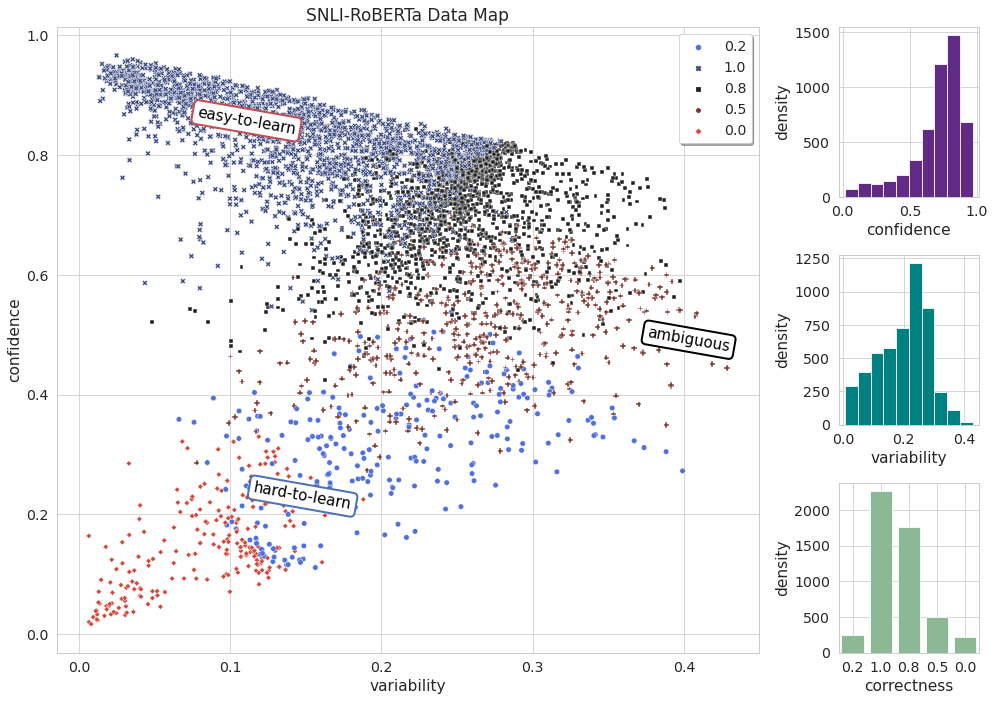

In [97]:
cart = Cartography(dataloader=train_dataloader,
                    num_labels=3,
                    num_epochs=4,
                    output_dir='./test/',
                    device='cuda',
                    model='roberta')

cart.training_dynamics_generation()

train_dy_metrics, _ = cart.compute_train_dynamics()

# Plotting
plots_dir = './test/plot_pdf/'
if not os.path.exists(plots_dir):
    os.makedirs(plots_dir)
cart.plot_data_map(train_dy_metrics, plots_dir, title='SNLI', show_hist=True, model='RoBERTa')

In [ ]:
# Moreover, datasets can be filtered with respect any of the other metrics.

def consider_ascending_order(filtering_metric: str) -> bool:
  """
  Determine if the metric values' sorting order to get the most `valuable` examples for training.
  """
  if filtering_metric == "variability":
    return False
  elif filtering_metric == "confidence":
    return True
  elif filtering_metric == "threshold_closeness":
    return False
  elif filtering_metric == "forgetfulness":
    return False
  elif filtering_metric == "correctness":
    return True
  else:
    raise NotImplementedError(f"Filtering based on {filtering_metric} not implemented!")

def write_filtered_data(filtering_output_dir, train_dy_metrics):
  """
  Filter data based on the given metric, and write it in TSV format to train GLUE-style classifier.
  """
  with open(os.path.join(filtering_output_dir, f"filtering_configs.json"), "w") as outfile:
    outfile.write(json.dumps(argparse_dict, indent=4, sort_keys=True) + "\n")

  # Determine whether to sort data in ascending order or not, based on the metric.
  is_ascending = consider_ascending_order(args.metric)
  if args.worst:
    is_ascending = not is_ascending

  # Sort by selection.
  sorted_scores = train_dy_metrics.sort_values(by=[args.metric],
                                               ascending=is_ascending)

  original_train_file = os.path.join(os.path.join(args.data_dir, args.task_name), f"train.tsv")
  train_numeric, header = read_data(original_train_file, task_name=args.task_name, guid_as_int=True)

  for fraction in [0.01, 0.05, 0.10, 0.1667, 0.25, 0.3319, 0.50, 0.75]:
    outdir = os.path.join(args.filtering_output_dir,
                          f"cartography_{args.metric}_{fraction:.2f}/{args.task_name}")
    if not os.path.exists(outdir):
      os.makedirs(outdir)

    # Dev and test need not be subsampled.
    copy_dev_test(args.task_name,
                  from_dir=os.path.join(args.data_dir, args.task_name),
                  to_dir=outdir)

    num_samples = int(fraction * len(train_numeric))
    with open(os.path.join(outdir, f"train.tsv"), "w") as outfile:
      outfile.write(header + "\n")
      selected = sorted_scores.head(n=num_samples+1)
      if args.both_ends:
        hardest = sorted_scores.head(n=int(num_samples * 0.7))
        easiest = sorted_scores.tail(n=num_samples - hardest.shape[0])
        selected = pd.concat([hardest, easiest])
        fm = args.metric
        logger.info(f"Selecting both ends: {fm} = "
                    f"({hardest.head(1)[fm].values[0]:3f}: {hardest.tail(1)[fm].values[0]:3f}) "
                    f"& ({easiest.head(1)[fm].values[0]:3f}: {easiest.tail(1)[fm].values[0]:3f})")

      selection_iterator = tqdm.tqdm(range(len(selected)))
      for idx in selection_iterator:
        selection_iterator.set_description(
          f"{args.metric} = {selected.iloc[idx][args.metric]:.4f}")

        selected_id = selected.iloc[idx]["guid"]
        if args.task_name in ["SNLI", "MNLI"]:
          selected_id = int(selected_id)
        elif args.task_name == "WINOGRANDE":
          selected_id = str(int(selected_id))
        record = train_numeric[selected_id]
        outfile.write(record + "\n")

    logger.info(f"Wrote {num_samples} samples to {outdir}.")

In [ ]:
# Filter data and save it
filtering_output_dir = './filtered_dataset/'
if not os.path.exists(filtering_output_dir):
    os.makedirs(filtering_output_dir)
write_filtered_data(filtering_output_dir, train_dy_metrics)